# Machine Learning

[walter.daelemans@uantwerpen.be](mailto:walter.daelemans@uantwerpen.be)

## Evaluation, Bias - Variance

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'sklearn: {sklearn.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
import sys
print(f'Python: {sys.version}')
!which python    

pandas: 2.1.4
numpy: 1.26.2
sklearn: 1.2.2
matplotlib: 3.8.0
Python: 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
/Users/walter/anaconda3/bin/python


This notebook starts from a pipeline for the adult_small data and will then explain and illustrate several ways of evaluating trained models.

In [5]:
# Load dataset
adult = pd.read_csv('homework/adult_small.csv')

# Remove duplicates
adult.drop_duplicates(inplace=True)
adult.sample(5)

,age,education.num,race,sex,hours.per.week,income
852,52,10,White,Male,40,<=50K
609,28,14,Black,Male,40,<=50K
848,52,6,White,Male,35,<=50K
4027,44,9,Black,Female,40,<=50K
4044,35,13,White,Male,40,<=50K


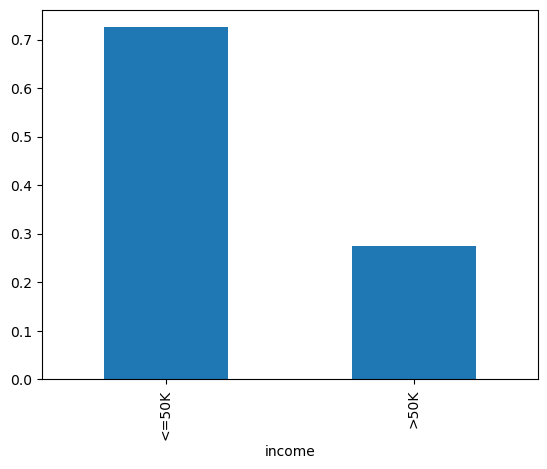

In [7]:
adult['income'].value_counts(normalize=True).plot(kind='bar');

In [13]:
# Features and target
X = adult.drop(columns=['income'])
y = adult['income']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape},\
 X_test: {X_test.shape}, y_test: {y_test.shape}\n")

# Preprocessing for numeric and categorical features

# Create two transformers and one estimator
ohe = OneHotEncoder()
scaler = StandardScaler()
logreg = LogisticRegression(solver='liblinear', random_state=42)

# no need here to make sub-pipelines, only one transformer needed per feature type
preprocessor = make_column_transformer(
    (scaler, ['age', 'education.num', 'hours.per.week']),
    (ohe, ['race', 'sex'])
)

# Create a pipeline with preprocessor and logistic regression
pipe = make_pipeline(preprocessor, logreg)
pipe

Shapes: X_train: (2641, 5), y_train: (2641,), X_test: (661, 5), y_test: (661,)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'education.num',
                                                   'hours.per.week']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['race', 'sex'])])),
                ('logisticregression',
                 LogisticRegression(random_state=42, solver='liblinear'))])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l1'}
Best Cross-Validation Score: 0.6632281292644202
              precision    recall  f1-score   support

       <=50K       0.81      0.94      0.87       481
        >50K       0.71      0.42      0.53       180

    accuracy                           0.80       661
   macro avg       0.76      0.68      0.70       661
weighted avg       0.78      0.80      0.78       661



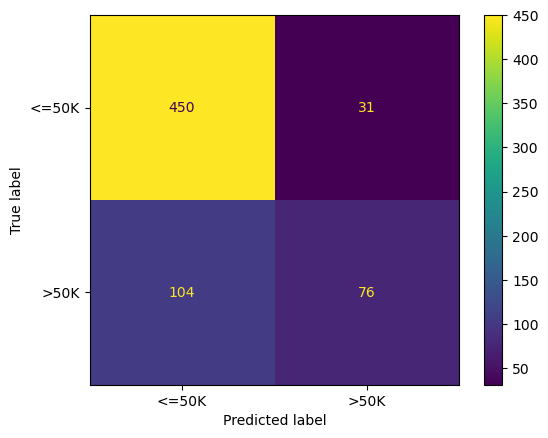

In [15]:
# Define parameter grid for GridSearchCV

# Nothing useful to optimize in the preprocessor (scaling, ohe)
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2']
}

# Instantiate GridSearchCV
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)

# Fit the model
gs.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", gs.best_params_)
print("Best Cross-Validation Score:", gs.best_score_)

# Test set performance
y_test_predicted = gs.predict(X_test)
print(classification_report(y_test, y_test_predicted))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predicted)


For reference: the different steps in doing ML in sklearn.

<img src="figures/sklearn_flow.png">

### Evaluation Metrics

Almost all relevant evaluation metrics can be derived from the confusion matrix.

- Accuracy is $\frac{TP + TN}{TP + TN + FP + FN}$


- Precision is $\frac{TP}{TP + FP}$
    - Also called positive predictive value
    

- Recall is $\frac{TP}{TP + FN}$
    - Also called sensitivity, true positive rate
    
    
- Specificity is $\frac{TN}{TN + FP}$  
    - Also called true negative rate

- F1-score is $2\frac{P * R}{P + R}$

- Macro-average P, R and F1 is the average over all classes

- Micro-average / weighted average is the frequency-weighted average over all classes

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html

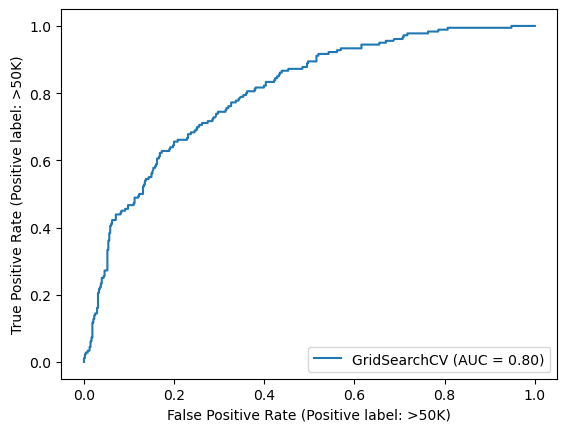

In [10]:
from sklearn.metrics import RocCurveDisplay
# Area under the curve 
RocCurveDisplay.from_estimator(gs, X_test, y_test)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html

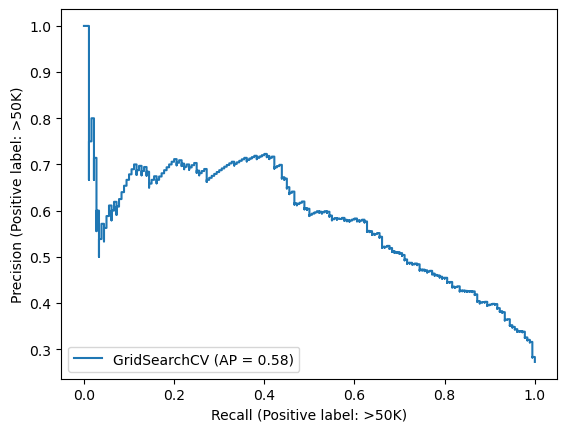

In [12]:
from sklearn.metrics import PrecisionRecallDisplay
# Precision - Recall curve

PrecisionRecallDisplay.from_estimator(gs, X_test, y_test)
# AP = Average Precision for the different recall values

### Generalization

- We can’t evaluate a trained model on the data we trained it on 
- We need separate train and test sets to evaluate generalization of a trained model
- We assume train and test data to be samples taken from the same population (the task we are trying to model), identically distributed
    - If that is the case, train and test set accuracy will be similar to each other, and  a good estimate of the “real” accuracy we will get on unseen data
    - If it is not the case, the model does not work in this case / on this data!

### Model Selection

- ML algorithms have (sometimes many) hyperparameters
- We want to select the best features and hyperparameter settings for our task
- In general: best = best generalization accuracy
    - But we might also be interested in interestingness, interpretability, ...
- We perform model selection on a development / validation set (part of the train data), not on the test data

### Cross-Validation

- Hold-out (train-test)
    - Keep part as train material (50-90%)
    - Use rest as test material (50-10%)
- Hold-out with model selection
    - Use part of train material as validation test set for optimization feature engineering and algorithm parameters
    - E.g. 80% train, 10% validation, 10% test
    - Train the final best model on train + validation test (90%), report score on test
- N-fold cross-validation
    - E.g. n=10 (10-fold cross-validation)
    - Create 10 splits of 10% of the data
    - Use each partition in turn as test data and the other nine partitions as train data 
    - Run 10 experiments 
    - Use part of train data each experiment for model selection
    - Report average and standard deviation
    - Advantages
        - More reliable error estimation
        - Insight into variance of the classifier
        - More reliable statistical significance tests in comparisons


<img src="figures/crossval.png">

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
print(scores)
print(f"Mean {scores.mean()}, Std {scores.std()}")

[0.62983673 0.65133427 0.72392157 0.69515607 0.69507867 0.62437228
 0.64690413 0.67823631 0.67547531 0.66694347]
Mean 0.6687258806605025, Std 0.029727149061165335


### Qualitative Error Analysis

- One way to do error analysis is to look at false positive and false negatives and try to come up with an explanation.

- More generally, it is possible to sort or label your test dataset with additional information / an additional typology, and look at accuracy of the model on this different subsets. 

In [23]:
# Make a dataframe with the true classes and the predicted classes
d = {'true': y_test, 'pred': y_test_predicted}
output = pd.DataFrame(data=d)
output.sample(5)

,true,pred
2616,<=50K,<=50K
124,>50K,>50K
1429,>50K,<=50K
616,<=50K,<=50K
2666,>50K,<=50K


In [25]:
print('False negatives:')
fn = output[(output['true'] == '>50K') & (output['pred'] == '<=50K')].index
fn
# the gold standard says 'high income' and the model says 'low income'

False negatives:


Index([ 212, 3409, 3531, 1713, 1429, 2166, 2749, 3037,   30, 2304,
       ...
       2046, 1702,  907, 2859,  112, 3678, 1042, 1153, 4395,  519],
      dtype='int64', length=104)

In [27]:
print('False positives:')
fp = output[(output['true'] == '<=50K') & (output['pred'] == '>50K')].index
fp

False positives:


Index([1013, 3938, 4059,  249, 2450, 3872, 4175, 1477, 3644,  186, 3429, 4702,
       1379, 2847, 4665,  566,  294, 2791, 3860, 1579, 1446, 1546,  145, 2690,
       1698, 3275, 2232,  744, 4346, 2504, 2999],
      dtype='int64')

In [29]:
adult.loc[fp]

,age,education.num,race,sex,hours.per.week,income
1013,43,12,White,Male,50,<=50K
3938,25,13,White,Male,60,<=50K
4059,55,16,White,Male,40,<=50K
249,36,15,White,Male,60,<=50K
2450,28,14,White,Male,60,<=50K
3872,56,14,White,Male,66,<=50K
4175,38,10,White,Male,75,<=50K
1477,50,13,White,Male,60,<=50K
3644,70,13,White,Male,40,<=50K
186,40,13,White,Male,53,<=50K


In [31]:
adult.race.value_counts(normalize=True)

race
White                 0.831617
Black                 0.123864
Asian-Pac-Islander    0.044518
Name: proportion, dtype: float64

In [35]:
adult.loc[fn].race.value_counts(normalize=True)

race
White                 0.836538
Black                 0.115385
Asian-Pac-Islander    0.048077
Name: proportion, dtype: float64

In [37]:
adult.loc[fp].race.value_counts(normalize=True)

race
White                 0.967742
Asian-Pac-Islander    0.032258
Name: proportion, dtype: float64

### Learning and Validation Curves

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html


In [26]:
from sklearn.model_selection import learning_curve, validation_curve

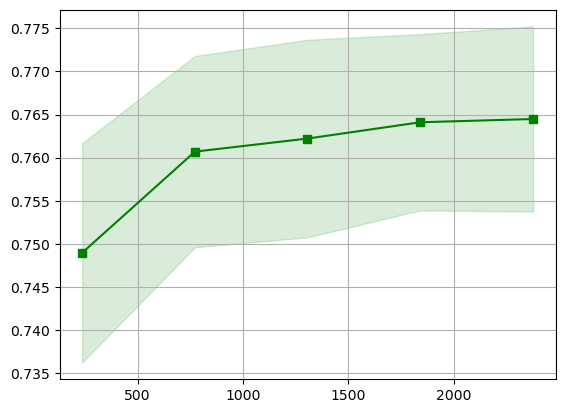

In [27]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_train, y=y_train, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, test_mean, color='green', marker='s')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()


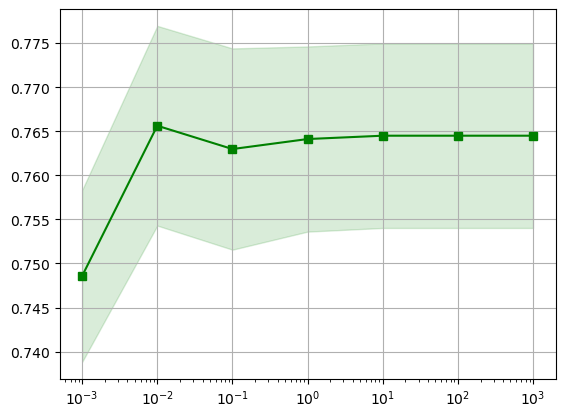

In [28]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = validation_curve(estimator=pipe, X=X_train, y=y_train, \
                                             param_name= 'logisticregression__C', param_range=param_range, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.show()

### Bias Variance trade-off (intuition)
illustration from Scott Fortmann-Roe

<img src="figures/bias-variance.png">

Overfitting: the model fits the data but generalizes badly
  - High Variance (different data partitions lead to different performance)

Underfitting: the model doesn't fit the data very well (and bad generalization)
   - High Bias
   - Solution: Other method needed
    
The only criterion for a model is it's generalization capacities!
        
Solutions for a "just right" model: 
   - Regularization (make the task more difficult for the algorithm, for example C parameter in logistic regression)
       - Cost function is extended with a term that tries to keep the weights small 
   - Feature selection (avoid that there are too many features for the number of samples)
   - More training data


### Regularization in Logistic Regression

Regularization prevents the model from relying too heavily on any single feature or fitting the training data too closely.

The two most common types of regularization in logistic regression are L1 and L2 regularization. They work by adding a **penalty** to the cost function. **L1** Regularization (Lasso Regularization) adds a penalty proportional to the sum of the absolute values of the coefficients. **L2** Regularization (Ridge Regularization) adds a penalty to the cost function proportional to the sum of the squares of the coefficients (weights). Regularization can drive some coefficients close to (or for L1 exactly to) zero, effectively removing less important features.

The strength of the regularization is (inversely) controlled by the parameter **C**.